In [1]:
from __future__ import print_function

import argparse
import csv
import os
import sys
import tifffile
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import glob
import pickle

import datetime
import math
import json
import time

import timm
from timm.models import create_model
from timm.scheduler import CosineLRScheduler
from timm.optim import create_optimizer
from timm.utils import NativeScaler, get_state_dict

from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.models as models
import torchvision.transforms as T
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import make_grid

import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler

from customloss import CustomLoss
from datamgr import *
import utils
from engine import *
from dataset import *
from models import *
from samplers import RASampler

import copy
from pathlib import Path
from tqdm import tqdm
%matplotlib inline

In [2]:
def parse_args():
    parser = argparse.ArgumentParser(description= 'CBNA training script')
    parser.add_argument('--model_type'       , default='CNN', help='CNN/MLP/ViT/Fusion')
    parser.add_argument('--data_set'     , default='CBNA')
    parser.add_argument('--data_path'     , default='Data/irc_patches/')
    parser.add_argument('--file_path'     , default='datafile/')
    parser.add_argument('--output_dir', default='checkpoints/', help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cpu', help='device to use for training / testing')
    parser.add_argument('--batch_size', default=128, type=int, help='Per-GPU batch-size : number of distinct images loaded on one GPU.')
    parser.add_argument('--input_size'  , default=224, type=int, help ='Image size for training')
    parser.add_argument('--drop_path'   , type=float, default=0.05)
    parser.add_argument('--eval_crop_ratio', default=0.875, type=float, help="Crop ratio for evaluation")
    parser.add_argument('--num_workers', default=8, type=int, help='Number of data loading workers per GPU.')
    parser.add_argument('--seed'       , default=0, type=int, help='seed')

    return parser.parse_args('')

args = parse_args()
output_dir = Path(args.output_dir).joinpath('{}/{}/'.format(args.data_set, args.model_type))
args.output_dir = output_dir
if not os.path.isdir(args.output_dir):
    try:
        os.makedirs(args.output_dir, exist_ok = True)
        print("Directory '%s' created successfully" %args.output_dir)
    except OSError as error:
        print("Directory '%s' can not be created")

if args.data_set == 'CBNA':
    args.classes = list(np.genfromtxt(Path(args.file_path).joinpath('classes.txt'), dtype='str'))
    args.num_classes = len(args.classes)
    print('number of labels: ', args.num_classes)

number of labels:  2522


In [3]:
utils.fix_random_seeds(args.seed)
cudnn.benchmark = True
num_tasks = utils.get_world_size()
global_rank = utils.get_rank()

dataset_test = build_dataset(args, is_train=False)
args.test_label_cnt = dataset_test.get_label_count()
print(f"Data loaded: there are {len(dataset_test)} test images.")
sampler_test = torch.utils.data.SequentialSampler(dataset_test)
test_loader = DataLoader(dataset_test, sampler=sampler_test, batch_size=args.batch_size, num_workers=args.num_workers, pin_memory=True, drop_last=False)

Data loaded: there are 15980 test images.


In [4]:
model = Resnet_CBNA(args, out_dim=args.num_classes)
model.to(args.device)

reload_file = utils.get_best_file(args.output_dir)        
print("best_file" , reload_file)

checkpoint = torch.load(reload_file, map_location='cpu')
model.load_state_dict(checkpoint['model'])
model.eval()
print("model loaded")

best_file checkpoints/CBNA/CNN/best.pth
model loaded


def normalise(tens):
    temp = tens.detach().cpu().numpy()
    return (255*(temp - np.min(temp))/np.ptp(temp)).astype(int)

weights = model_without_ddp.conv1.weight
print('filter shape: ', weights.shape)

fig,axes = plt.subplots(2, 8, figsize=(15,5))
ch = weights.shape[1]

arr = np.arange(ch)
np.random.shuffle(arr)

selected_ch = arr[:3]
selected_weights = weights[:, selected_ch, :,:]

for i in range(16):
    axes.ravel()[i].axis('off')
    axes.ravel()[i].imshow(normalise(selected_weights[i].permute(1,2,0)), interpolation = 'bilinear')
    axes.ravel()[i].set_title(i)
fig.suptitle('Filters', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

113260.0,124798.0,128419.0,105400.0,109869.0,81272.0,88741.0,90208.0,104173.0,85957.0,125024.0,717574.0,99418.0,109150.0,128077.0,107038.0,107090.0,109091.0,108027.0,124034.0,92353.0,138682.0


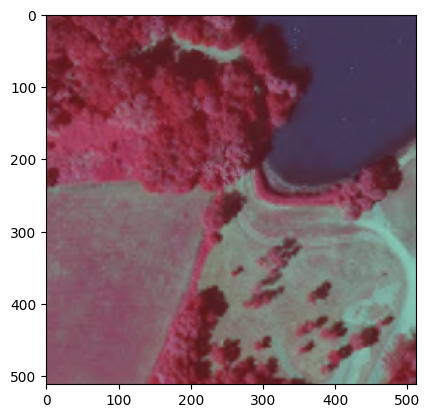

In [6]:
idx = 74
image, target = dataset_test[idx]
img = dataset_test.show_sample(idx)
image = image.to(args.device)
target = target.to(args.device)
with torch.no_grad():
    preds = torch.sigmoid(model(image.unsqueeze(0)))

In [7]:
class fHook():
    def hook_f(self, module, inp, out): 
        self.inp_stored = inp
        self.out_stored = out.detach().clone()
        
class bHook():
    def hook_bwd_f(self, module, inp, out):
        self.out_stored = out[0].detach().clone()  

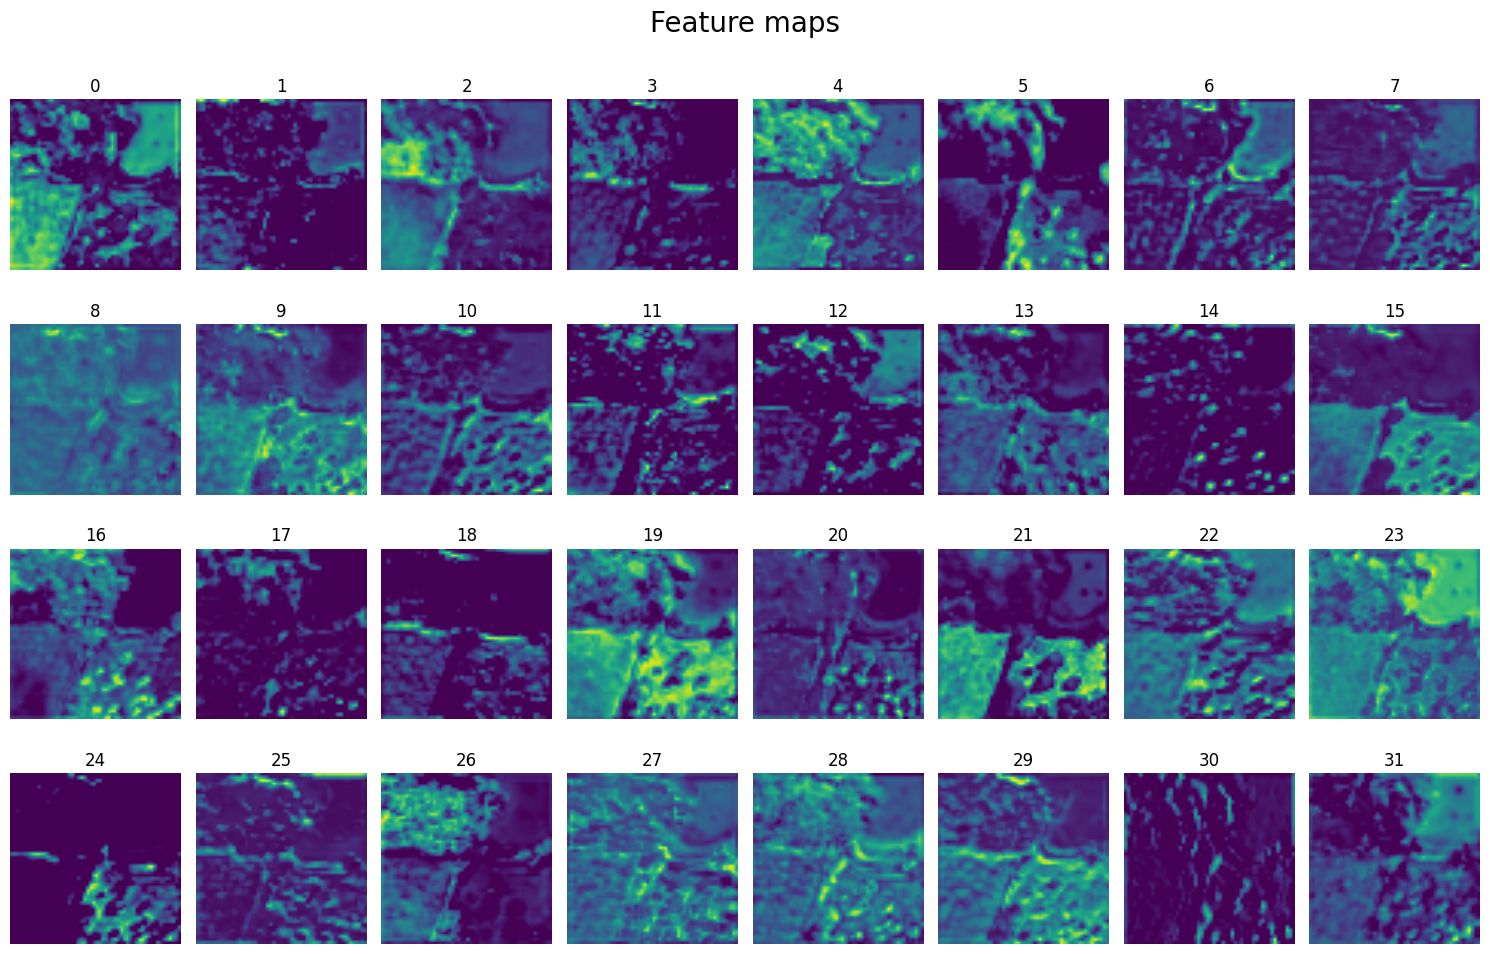

In [8]:
hook_data = fHook() # Creating an instance of the hook
hook_new = model.base_model.layer1.register_forward_hook(hook_data.hook_f) # Attaching it to the first layer of the model
with torch.no_grad(): 
    output = model(image.unsqueeze(0)) # Propagating an image through the network to get all the layers working
hook_new.remove() # Removing the hook

fm = hook_data.out_stored

fig,axes = plt.subplots(4, 8, figsize=(15,10))
for i in range(32):
    axes.ravel()[i].imshow(fm[0][i].detach().cpu(), interpolation='bilinear')
    axes.ravel()[i].axis('off')
    axes.ravel()[i].set_title(i)
fig.suptitle('Feature maps', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

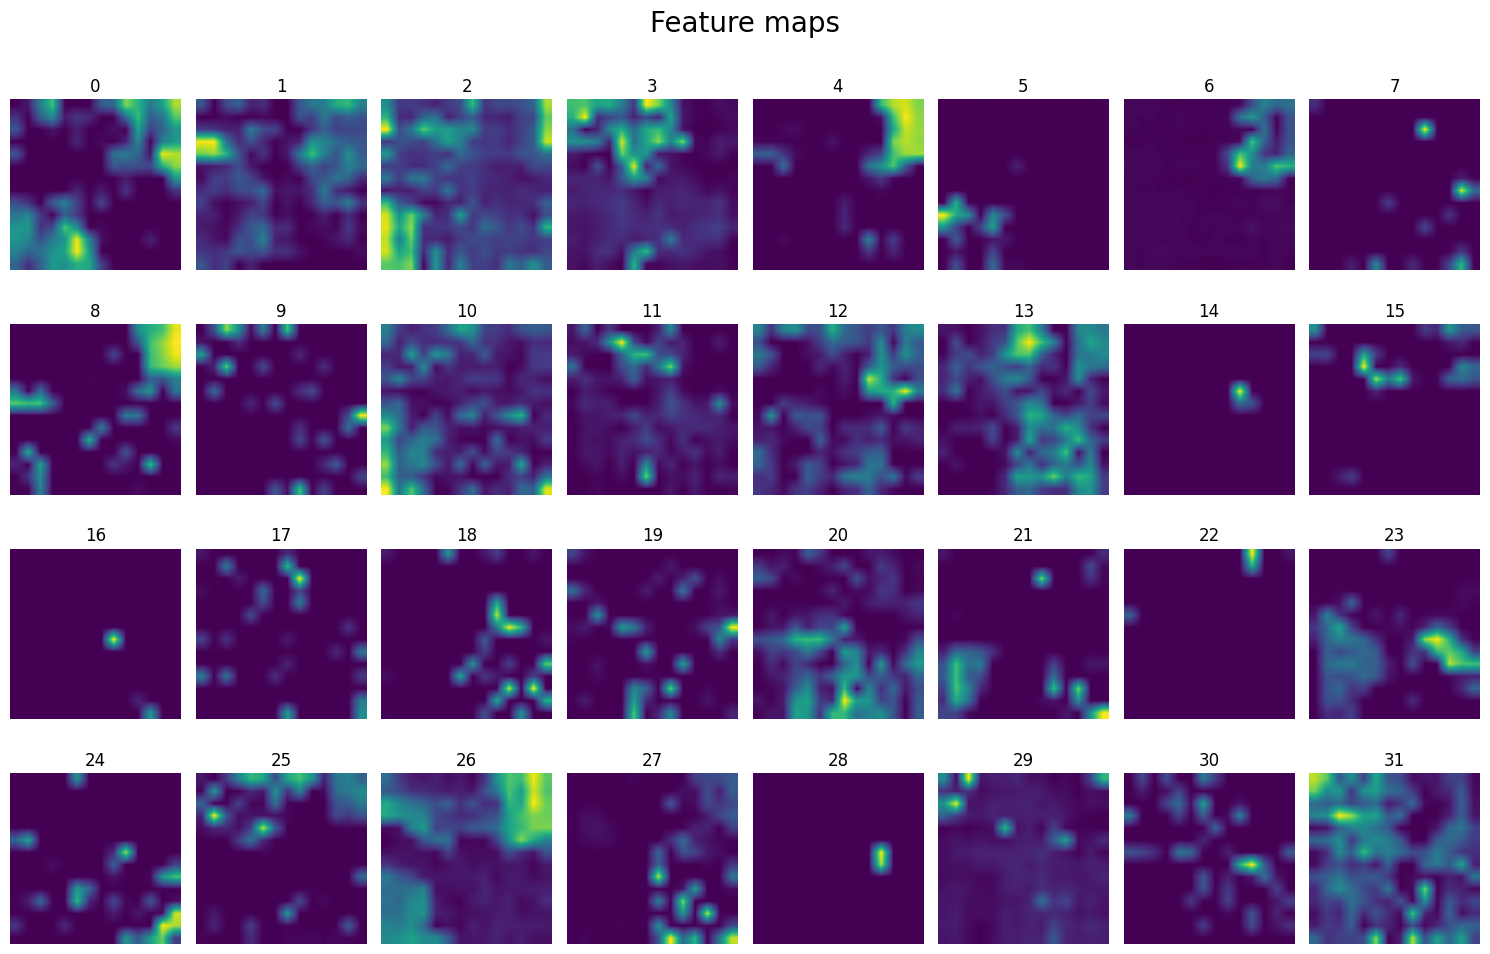

In [9]:
hook_data = fHook() # Creating an instance of the hook
hook_new = model.base_model.layer3.register_forward_hook(hook_data.hook_f) # Attaching it to the first layer of the model
with torch.no_grad(): 
    output = model(image.unsqueeze(0)) # Propagating an image through the network to get all the layers working
hook_new.remove() # Removing the hook

fm = hook_data.out_stored

fig,axes = plt.subplots(4, 8, figsize=(15,10))
for i in range(32):
    axes.ravel()[i].imshow(fm[0][i].detach().cpu(), interpolation='bilinear')
    axes.ravel()[i].axis('off')
    axes.ravel()[i].set_title(i)
fig.suptitle('Feature maps', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

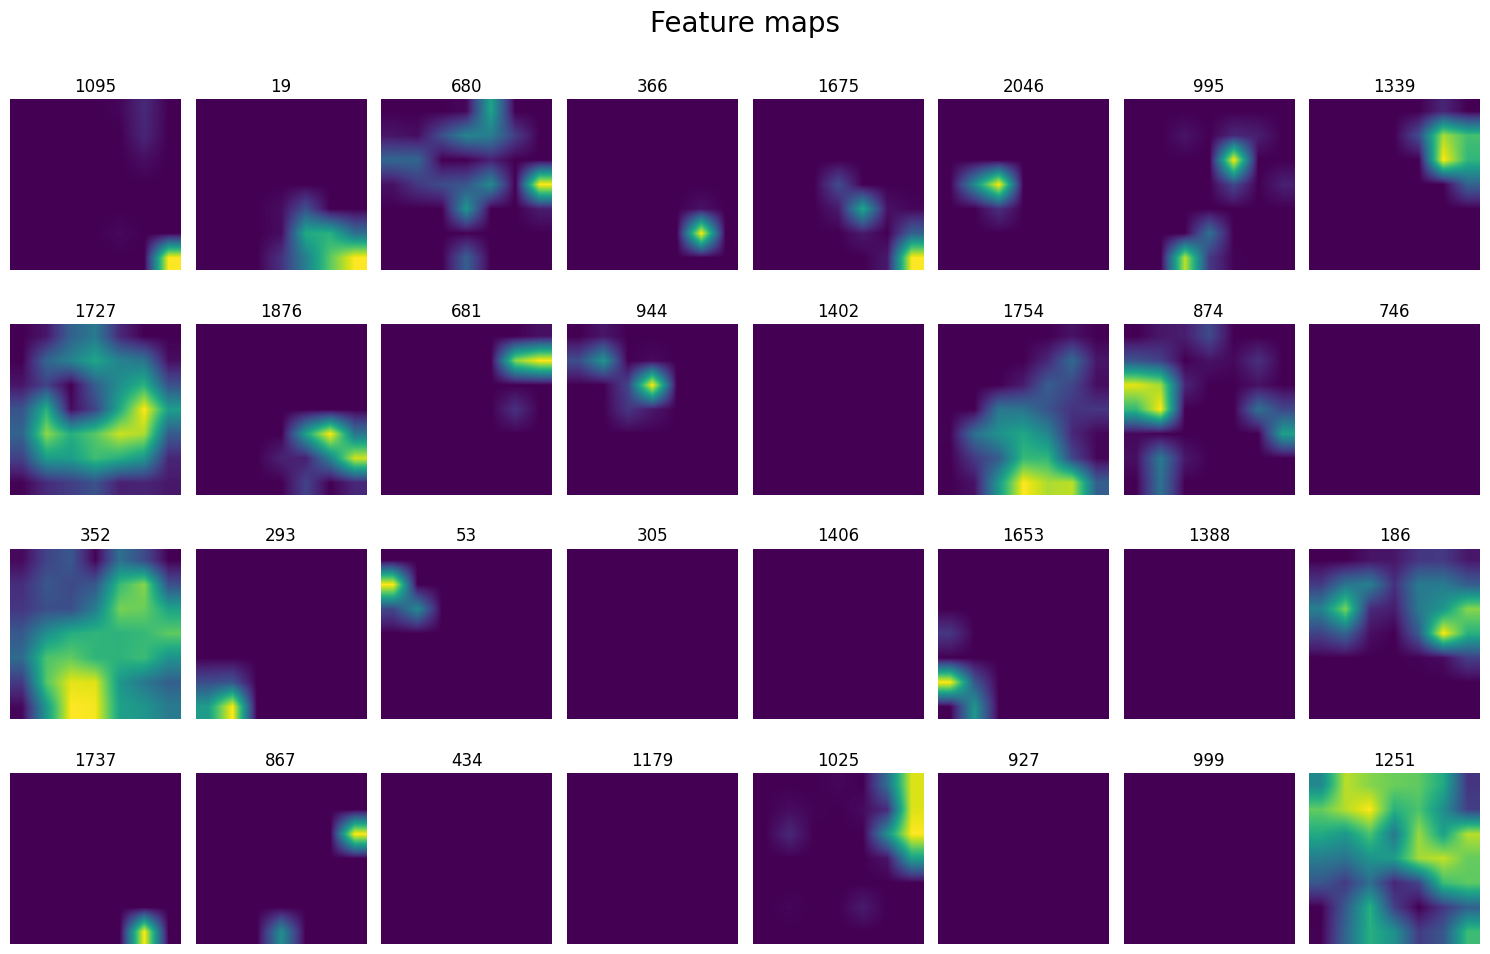

In [10]:
hook_data = fHook() # Creating an instance of the hook
hook_new = model.base_model.layer4.register_forward_hook(hook_data.hook_f) # Attaching it to the last layer of the model
with torch.no_grad():
    output = model(image.unsqueeze(0)) # Propagating an image through the network to get all the layers working
hook_new.remove() # Removing the hook

fm_last = hook_data.out_stored

sample64 = random.sample(range(2048), 32)
fig,axes = plt.subplots(4, 8, figsize=(15,10))
for i,ind in enumerate(sample64):
    axes.ravel()[i].imshow(fm_last[0][ind].detach().cpu(), interpolation='bilinear')
    axes.ravel()[i].axis('off')
    axes.ravel()[i].set_title(ind)
fig.suptitle('Feature maps', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

conv_out = []
hook_data = fHook()
for layer in model_without_ddp.modules():
    if isinstance(layer, torch.nn.modules.conv.Conv2d):
        hook_handler = layer.register_forward_hook(hook_data.hook_f)
        output = model_without_ddp(image.unsqueeze(0))
        conv_out.append(hook_data.out_stored[0])
        hook_handler.remove()

from matplotlib import animation, rc
from IPython.display import HTML
fig, ax = plt.subplots(3, 5, figsize=(5,3), dpi = 150)
title = plt.suptitle(t='', fontsize = 12)
fig.subplots_adjust(top=0.92)

def animate_tensors(i, pic_num = 15):
    tens = conv_out[i]
    
    tens_positions = random.sample(range(tens.shape[0]), pic_num)
    to_plot_maps = tens[tens_positions]
    
    for j in range(pic_num):
        ax.ravel()[j].imshow(to_plot_maps[j].detach().cpu(), interpolation='bilinear')
        ax.ravel()[j].axis('off')
        title.set_text('Feature map {}'.format(i))
        plt.tight_layout()

anim = animation.FuncAnimation(fig, animate_tensors, frames= len(conv_out), interval=1500, repeat=True)

plt.close()
HTML(anim.to_html5_video())

In [17]:
#anim.save('dynamic_images.mp4')